In [1]:
from collections import Counter, defaultdict
from itertools import count, chain
import random
import math

import dynet as dy
import numpy as np

In [2]:
# format of files: each line is "word1/tag2 word2/tag2 ..."
train_file="data/cleaned/train.BIEOU.tsv"
test_file="data/cleaned/dev.BIEOU.tsv"

MAX_LIK_ITERS = 3
SMALL_NUMBER = -1e10
MARGIN = 0


In [3]:
class Vocab:
    def __init__(self, w2i=None):
        if w2i is None: w2i = defaultdict(count(0).next)
        self.w2i = dict(w2i)
        self.i2w = {i:w for w,i in w2i.iteritems()}
    @classmethod
    def from_corpus(cls, corpus):
        w2i = defaultdict(count(0).next)
        for sent in corpus:
            [w2i[word] for word in sent]
        return Vocab(w2i)

    def size(self): 
        return len(self.w2i.keys())


In [4]:
def read(fname):
    """
    Read a NER-tagged file where each line is of the form "word1 tag2\nword2 tag2 ..."
    Yields lists of the form [(word1,tag1), (word2,tag2), ...]
    """
    with file(fname) as fh:
        sent = []
        for line in fh:
            line = line.strip()
            if line == "":
                if sent:
                    yield sent
                sent = []
                continue
            if line:
                line = tuple(line.split("\t"))
                sent.append(line)
    if sent:
        yield sent


In [5]:
train=list(read(train_file))
test=list(read(test_file))
print("Train: %s, Test: %s" % (len(train), len(test)))

Train: 2394, Test: 1000


In [6]:
print(train[0])

[('@SammieLynnsMom', 'O'), ('@tg10781', 'O'), ('they', 'O'), ('will', 'O'), ('be', 'O'), ('all', 'O'), ('done', 'O'), ('by', 'O'), ('Sunday', 'O'), ('trust', 'O'), ('me', 'O'), ('*wink*', 'O')]


In [7]:
words=[]
tags=[]
chars=set()
wc=Counter()
for sent in train:
    for w,p in sent:
        words.append(w)
        tags.append(p)
        chars.update(w)
        wc[w]+=1
words.append("_UNK_")
words.append("_S_")
tags.append("_S_")
chars.add("<*>")

In [8]:
vw = Vocab.from_corpus([words]) # TODO Vocab
vt = Vocab.from_corpus([tags])
vc = Vocab.from_corpus([chars])
UNK = vw.w2i["_UNK_"]
S_W = vw.w2i["_S_"]
S_T = vt.w2i["_S_"]

In [9]:
nwords = vw.size()
ntags  = vt.size()
nchars  = vc.size()

In [10]:
print(nwords, ntags, nchars)

(10588, 42, 93)


In [11]:
# DyNet Starts

model = dy.Model()
trainer = dy.AdamTrainer(model)

WORDS_LOOKUP = model.add_lookup_parameters((nwords, 128))
CHARS_LOOKUP = model.add_lookup_parameters((nchars, 20))
TRANS_LOOKUP = model.add_lookup_parameters((ntags, ntags))
p_t1  = model.add_lookup_parameters((ntags, 30))

# MLP on top of biLSTM outputs 100 -> 32 -> ntags
pH = model.add_parameters((32, 50*2))
pO = model.add_parameters((ntags, 32))

# word-level LSTMs
fwdRNN = dy.LSTMBuilder(1, 128, 50, model) # layers, in-dim, out-dim, model
bwdRNN = dy.LSTMBuilder(1, 128, 50, model)

# char-level LSTMs
cFwdRNN = dy.LSTMBuilder(1, 20, 64, model)
cBwdRNN = dy.LSTMBuilder(1, 20, 64, model)

In [12]:
def word_rep(w, cf_init, cb_init):
    if wc[w] > 5:
        w_index = vw.w2i[w]
        return WORDS_LOOKUP[w_index]
    else:
        pad_char = vc.w2i["<*>"]
        char_ids = [pad_char] + [vc.w2i[c] for c in w] + [pad_char]
        char_embs = [CHARS_LOOKUP[cid] for cid in char_ids]
        fw_exps = cf_init.transduce(char_embs)
        bw_exps = cb_init.transduce(reversed(char_embs))
        return dy.concatenate([ fw_exps[-1], bw_exps[-1] ])


In [13]:
def build_tagging_graph(words):
    dy.renew_cg()
    # parameters -> expressions
    H = dy.parameter(pH)
    O = dy.parameter(pO)

    # initialize the RNNs
    f_init = fwdRNN.initial_state()
    b_init = bwdRNN.initial_state()

    cf_init = cFwdRNN.initial_state()
    cb_init = cBwdRNN.initial_state()

    # get the word vectors. word_rep(...) returns a 128-dim vector expression for each word.
    wembs = [word_rep(w, cf_init, cb_init) for w in words]
    wembs = [dy.noise(we,0.1) for we in wembs] # optional

    # feed word vectors into biLSTM
    fw_exps = f_init.transduce(wembs)
    bw_exps = b_init.transduce(reversed(wembs))
# OR
#    fw_exps = []
#    s = f_init
#    for we in wembs:
#        s = s.add_input(we)
#        fw_exps.append(s.output())
#    bw_exps = []
#    s = b_init
#    for we in reversed(wembs):
#        s = s.add_input(we)
#        bw_exps.append(s.output())

    # biLSTM states
    bi_exps = [dy.concatenate([f,b]) for f,b in zip(fw_exps, reversed(bw_exps))]

    # feed each biLSTM state to an MLP
    exps = []
    for bi in bi_exps:
        r_t = O*(dy.tanh(H * bi))
        exps.append(r_t)

    return exps

In [14]:
def viterbi_decoding(vecs, gold_tags = []):
    # Initialize
    init_prob = [SMALL_NUMBER] * ntags
    init_prob[S_T] = 0
    for_expr = dy.inputVector(init_prob)
    best_ids = []
    trans_exprs = [TRANS_LOOKUP[tid] for tid in range(ntags)]
    # Perform the forward pass through the sentence
    for i, vec in enumerate(vecs):
        my_best_ids = []
        my_best_exprs = []
        for next_tag in range(ntags):
            # Calculate vector for single next tag
            next_single_expr = for_expr + trans_exprs[next_tag]
            next_single = next_single_expr.npvalue()
            # Find and save the best score
            my_best_id = np.argmax(next_single)
            my_best_ids.append(my_best_id)
            my_best_exprs.append(dy.pick(next_single_expr, my_best_id))
        # Concatenate the scores for all vectors together
        for_expr = dy.concatenate(my_best_exprs) + vec
        # Give a bonus to all but the correct tag if using margin
        if MARGIN != 0 and len(gold_tags) != 0:
            adjust = [MARGIN] * ntags
            adjust[vt.w2i[gold_tags[i]]] = 0
            for_expr = for_expr + dy.inputVector(adjust)
        # Save the best ids
        best_ids.append(my_best_ids)
    # Perform the final step to the sentence terminal symbol
    next_single_expr = for_expr + trans_exprs[S_T]
    next_single = next_single_expr.npvalue()
    my_best_id = np.argmax(next_single)
    best_expr = dy.pick(next_single_expr, my_best_id)
    # Perform the reverse pass
    best_path = [vt.i2w[my_best_id]]
    for my_best_ids in reversed(best_ids):
        my_best_id = my_best_ids[my_best_id]
        best_path.append(vt.i2w[my_best_id])
    best_path.pop() # Remove final <s>
    best_path.reverse()
    # Return the best path and best score as an expression
    return best_path, best_expr

def forced_decoding(vecs, tags):
    # Initialize
    for_expr = dy.scalarInput(0)
    for_tag = S_T
    # Perform the forward pass through the sentence
    for i, vec in enumerate(vecs): 
        my_tag = vt.w2i[tags[i]]
        for_expr = for_expr + dy.pick(TRANS_LOOKUP[my_tag], for_tag) + vec[my_tag]
        for_tag = my_tag
    for_expr = for_expr + dy.pick(TRANS_LOOKUP[S_T], for_tag)
    return for_expr

def viterbi_sent_loss(words, tags):
    vecs = build_tagging_graph(words)
    viterbi_tags, viterbi_score = viterbi_decoding(vecs, tags)
    if viterbi_tags != tags:
        reference_score = forced_decoding(vecs, tags)
        return viterbi_score - reference_score
    else:
        return dy.scalarInput(0)

def sent_loss(words, tags):
    vecs = build_tagging_graph(words)
    errs = []
    for v,t in zip(vecs,tags):
        tid = vt.w2i[t]
        err = dy.pickneglogsoftmax(v, tid)
        errs.append(err)
    return dy.esum(errs)

def tag_sent(words):
    vecs = build_tagging_graph(words)
    vecs = [dy.softmax(v) for v in vecs]
    probs = [v.npvalue() for v in vecs]
    tags = []
    for prb in probs:
        tag = np.argmax(prb)
        tags.append(vt.i2w[tag])
    return tags


In [27]:
num_tagged = cum_loss = 0
token_scores = []
sent_scores = []
avg_loss = []
for ITER in xrange(50):
    random.shuffle(train)
    for i,s in enumerate(train,1):
        if i % 500 == 0:
            trainer.status()
            avg_loss.append(cum_loss / num_tagged)
            cum_loss = 0
            num_tagged = 0
        if i % 10000 == 0 or i == len(train)-1: 
            good_sent = bad_sent = good = bad = 0.0
            for sent in test:
                words = [w for w,t in sent]
                golds = [t for w,t in sent]
                if ITER < MAX_LIK_ITERS:
                    tags = tag_sent(words)
                else:
                    vecs = build_tagging_graph(words)
                    tags, loss_exp = viterbi_decoding(vecs)
                if tags == golds: good_sent += 1
                else: bad_sent += 1
                for go,gu in zip(golds,tags):
                    if go == gu: good += 1
                    else: bad += 1
            #print good/(good+bad), good_sent/(good_sent+bad_sent)
            token_scores.append(good/(good+bad))
            sent_scores.append(good_sent/(good_sent+bad_sent))
        # train on sent
        words = [w for w,t in s]
        golds = [t for w,t in s]

        if ITER < MAX_LIK_ITERS:
            loss_exp =  sent_loss(words, golds)
        else:
            loss_exp =  viterbi_sent_loss(words, golds)
        cum_loss += loss_exp.scalar_value()
        num_tagged += len(golds)
        loss_exp.backward()
        trainer.update()
    print "epoch %r finished" % ITER
    trainer.update_epoch(1.0)

epoch 0 finished
epoch 1 finished
epoch 2 finished
epoch 3 finished
epoch 4 finished
epoch 5 finished
epoch 6 finished
epoch 7 finished
epoch 8 finished
epoch 9 finished
epoch 10 finished
epoch 11 finished
epoch 12 finished
epoch 13 finished
epoch 14 finished
epoch 15 finished
epoch 16 finished
epoch 17 finished
epoch 18 finished
epoch 19 finished
epoch 20 finished
epoch 21 finished
epoch 22 finished
epoch 23 finished
epoch 24 finished
epoch 25 finished
epoch 26 finished
epoch 27 finished
epoch 28 finished
epoch 29 finished
epoch 30 finished
epoch 31 finished
epoch 32 finished
epoch 33 finished
epoch 34 finished
epoch 35 finished
epoch 36 finished
epoch 37 finished
epoch 38 finished
epoch 39 finished
epoch 40 finished
epoch 41 finished
epoch 42 finished
epoch 43 finished
epoch 44 finished
epoch 45 finished
epoch 46 finished
epoch 47 finished
epoch 48 finished
epoch 49 finished


In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("poster")
sns.set_style("ticks")

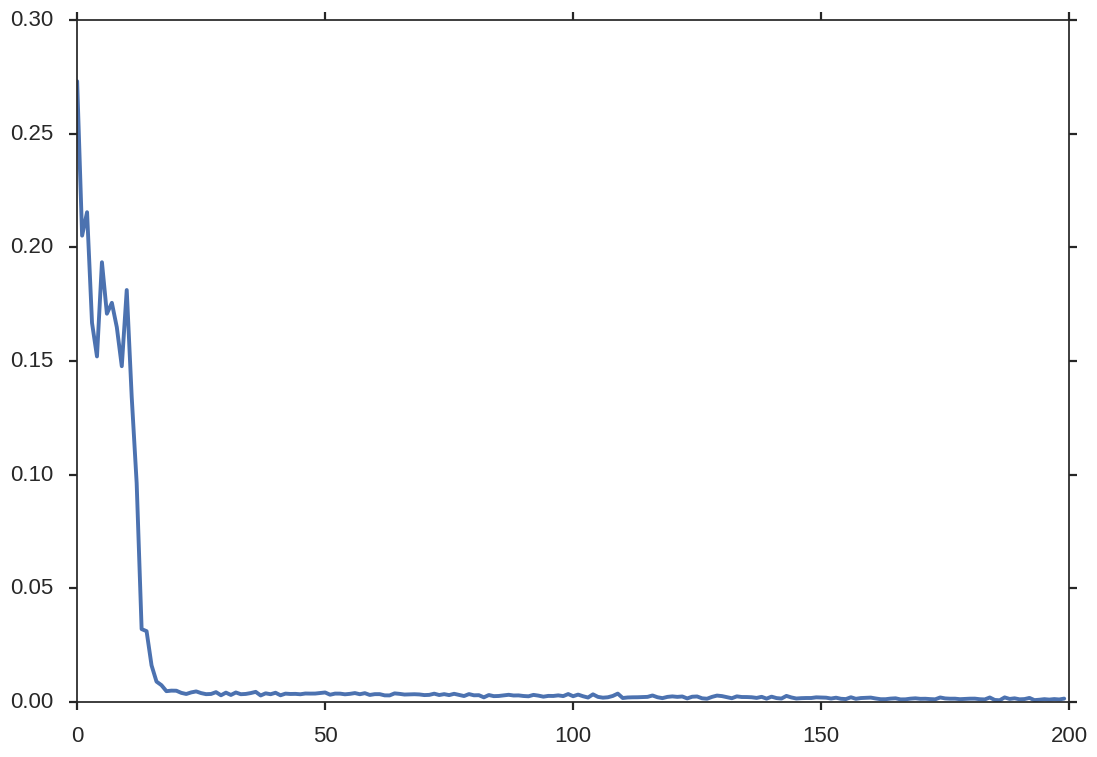

In [29]:
plt.plot(avg_loss)

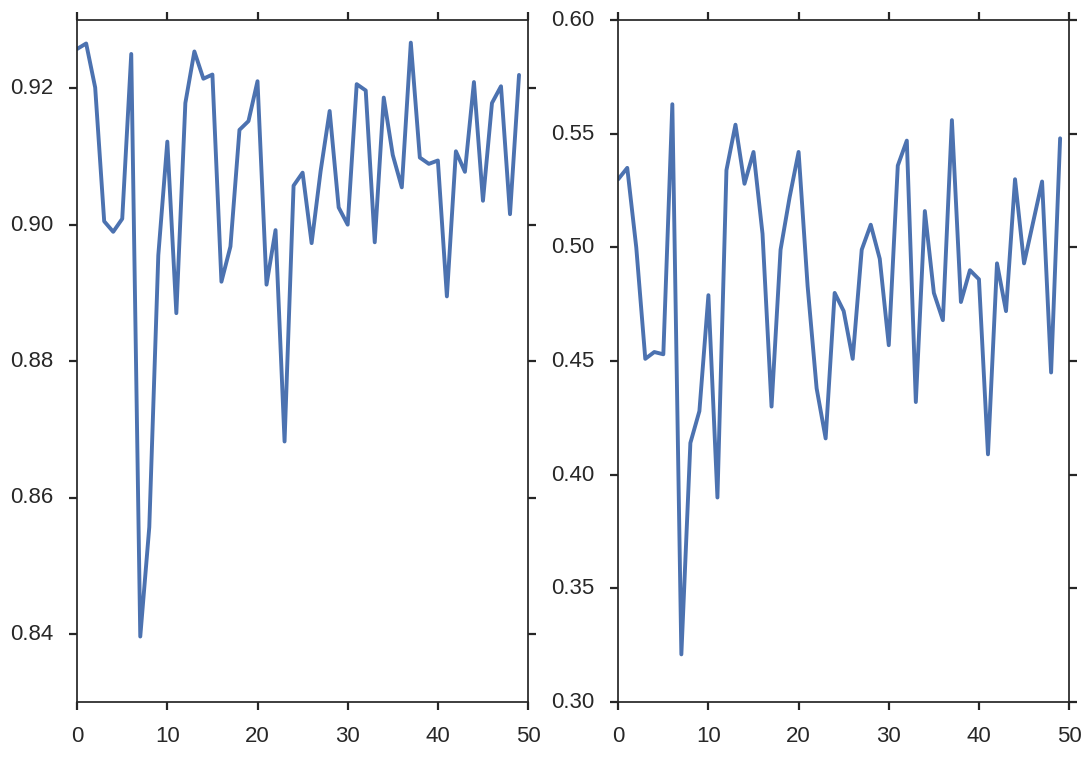

In [30]:
fig, ax = plt.subplots(1,2)
ax[0].plot(token_scores)
ax[1].plot(sent_scores)

In [39]:
def predict(sent, viterbi=True):
    words = [w for w,t in sent]
    golds = [t for w,t in sent]
    if viterbi:
        vecs = build_tagging_graph(words)
        tags, loss_exp = viterbi_decoding(vecs)
    else:
        tags = tag_sent(words)
    return tags

In [40]:
zip(test[2], predict(test[2]))

[(('RT', 'O'), 'O'),
 (('@shashiranjanttv', 'O'), 'O'),
 ((':', 'O'), 'O'),
 (('@shashiranjanttv', 'O'), 'O'),
 (('second', 'O'), 'O'),
 (('is', 'O'), 'O'),
 (('Bawana', 'U-geo-loc'), 'U-person'),
 (('constituency', 'O'), 'O'),
 (('on', 'O'), 'O'),
 (('Feb', 'O'), 'O'),
 (('4', 'O'), 'O'),
 (('-', 'O'), 'O'),
 (('Final', 'O'), 'O')]

In [33]:
def print_sequences(sequences, predictions, filename, test_data=False, notypes=False):
    with open(filename, "wb+") as fp:
        for seq, pred in zip(sequences, predictions):
            for t, p in zip(seq, pred):
                token, tag = t
                if tag[0] == "U":
                    tag = "B%s" % tag[1:]
                if tag[0] == "E":
                    tag = "I%s" % tag[1:]
                if p[0] == "U":
                    p = "B%s" % p[1:]
                if p[0] == "E":
                    p = "I%s" % p[1:]
                if notypes:
                    tag = tag[0]
                    p = p[0]
                if test_data:
                    line = "\t".join((token, p))
                else:
                    line = "\t".join((token, tag, p))
                print >> fp, line
            print >> fp, ""
    print "Done"

In [41]:
print_sequences(test, [predict(s) for s in test], "test.dynet.tsv")

Done


In [42]:
! cat test.dynet.tsv | tr '\t' ' ' | perl -ne '{chomp;s/\r//g;print $_,"\n";}' | python data/conlleval.py

processed 16261 tokens with 665 phrases; found: 473 phrases; correct: 86.
accuracy:  92.15%; precision:  18.18%; recall:  12.93%; FB1:  15.11
          company: precision:  18.75%; recall:  15.38%; FB1:  16.90  32
         facility: precision:  21.43%; recall:   7.69%; FB1:  11.32  14
          geo-loc: precision:  19.77%; recall:  29.31%; FB1:  23.61  172
            movie: precision:   0.00%; recall:   0.00%; FB1:   0.00  9
      musicartist: precision:   0.00%; recall:   0.00%; FB1:   0.00  5
            other: precision:  17.05%; recall:  11.36%; FB1:  13.64  88
           person: precision:  28.40%; recall:  13.45%; FB1:  18.25  81
          product: precision:   1.85%; recall:   2.70%; FB1:   2.20  54
       sportsteam: precision:  25.00%; recall:   5.71%; FB1:   9.30  16
           tvshow: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
